# Homework2 - Conditional Generative Adversarial Network (cGAN)
This is the sample code of homework 2 of the IMVFX course by Prof. I-Chen Lin

In this homework, you are required to build a conditional generative adversarial network for image generation.

Should you have any question, contact TA via <br/> ee81280@gmail.com


Sample code for cGAN, include the structure and train function.
You can start from this file or write your own structure and train function.
You can also modify anything in this file for training.

What you need to do:
1. Load your dataset.
2. Train the cGAN model and generate images with different conditions.
3. Plot the training loss of generator and discriminator.
4. Use trained cGAN model to generate images with conditions.


If you not familiar with Colab, [here](https://colab.research.google.com/drive/1ecb4-tImhe2CD6DSzxJtt63CAxt2c_Ap) provide the basic Colab knowledge needed to finish this homework.

# Set up the environment


## Packages Installation

In [9]:
# You may replace the workspace directory if you want.
workspace_dir = '.'

# Training progress bar
# !pip install -q qqdm

## Import Packages

First, we need to import packages that will be used later.

In [3]:
import os
import glob 
import random
from PIL import Image

import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm

# Random seed
Set the random seed to a certain value for reproducibility.

In [4]:
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Set random seed for reproducibility
same_seeds(123)

# Hyperparameters and Initialization
Let’s define some inputs for the run later:

In [61]:
# Root directory for dataset
dataroot = "dataset"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# The size of images
image_size = 28

# Number of channels in the training images. For gray images this is 1
nc = 1

# Size of z latent vector 
nz = 1000

# Number of image classes (i.e. 0-9)
nclass = 10

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# The weight for L1 loaa
lamb = 100

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Save checkpoints every few epochs
save_steps = 5

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# log(img), checkpoints and results directory
log_dir = os.path.join(workspace_dir, 'logs/cGAN')    # For evaluation results
ckpt_dir = os.path.join(workspace_dir, 'checkpoints/cGAN')    # For trained model weights
result_dir = os.path.join(workspace_dir, 'results/cGAN')    # For testing results
os.makedirs(log_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

# Load training data

In [18]:
# Define training and testing data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the train dataset
train_dataset = dset.MNIST(dataroot, train=True, download=True, transform=transform)
# Create the train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

## Show some training datas

In [19]:
examples = enumerate(train_dataloader)
batch_idx, (example_data, example_targets) = next(examples)

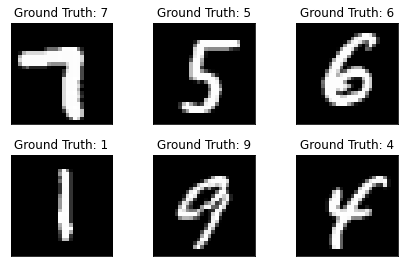

In [20]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

# Setup Model
Here, we use conditional generative adversarial nets as the model structure. Feel free to modify your own model structure.

## Weight Initialization

In [21]:
# custom weights initialization called on netG and netD
def weights_init(net):
    def init_func(m):
      classname = m.__class__.__name__
      if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
      elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
      elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
      
    net.apply(init_func)

## Generator

In [22]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # The size of generator input.
        input_dim = nz + nclass
        # The size of generator output.
        output_dim = image_size*image_size

        # It will have a 10-dimensional encoding for all the 10 digits.
        self.label_embedding = nn.Embedding(nclass, nclass)
        
        self.main = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Linear(256, 512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Linear(512, 1024),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Linear(1024, output_dim),
            nn.Tanh()
        )
    
    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = torch.cat([x,c], dim=1)
        output = self.main(x)
        return output

## Discriminator

In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # The size of discriminator input.
        input_dim = image_size*image_size + nclass
        # The size of discriminator output.
        output_dim = 1
        # It will have a 10-dimensional encoding for all the 10 digits.
        self.label_embedding = nn.Embedding(nclass, nclass)

        self.main = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )


    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = torch.cat([x, c], dim=1)
        output = self.main(x)

        return output

# Train

## Initialization for cGAN

In [62]:
# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
weights_init(netG)

# Print the model
print(netG)

Generator(
  (label_embedding): Embedding(10, 10)
  (main): Sequential(
    (0): Linear(in_features=1010, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)


In [63]:
# Create the Discriminator
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
weights_init(netD)

# Print the model
print(netD)

Discriminator(
  (label_embedding): Embedding(10, 10)
  (main): Sequential(
    (0): Linear(in_features=794, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [64]:
# Initialize Loss functions
criterionGAN = nn.BCELoss().to(device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.

# Create the latent vectors and condition labels that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(100, nz, device=device)
fixed_labels = torch.randint(0, 10, (100,)).to(device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


## Training loop

Starting Training Loop...


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  75.67it/s  0.6029  2.4531    1    468              

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

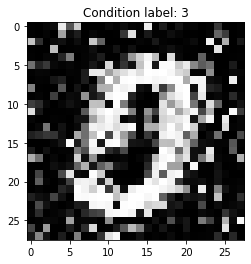

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  80.94it/s  0.2682  0.8282    2    937              

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

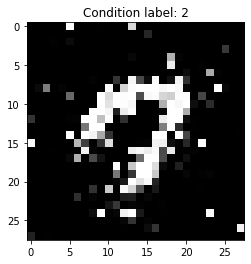

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  79.38it/s  0.4739  2.8128    3    1406             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

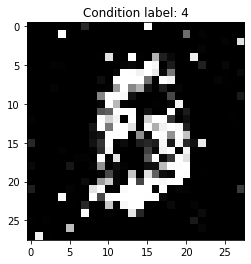

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  80.70it/s  0.2122  2.8813    4    1875             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

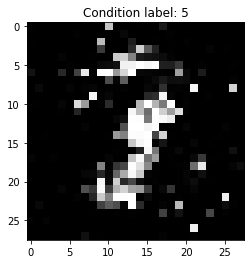

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  80.47it/s  0.328   1.3479    5    2344             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

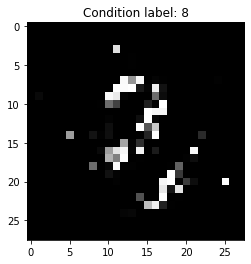

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  73.04it/s  0.2222  2.2419    6    2813             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

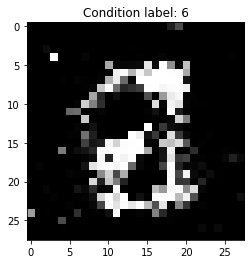

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  81.65it/s  0.2193  2.547     7    3282             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

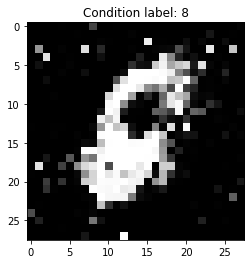

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  83.17it/s  0.2942  2.0379    8    3751             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

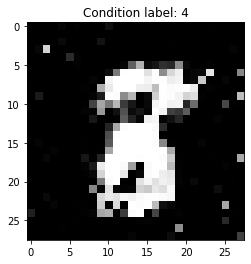

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  78.83it/s  0.3848  2.3801    9    4220             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

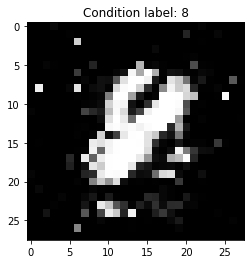

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  83.14it/s  0.4116  1.0899   10    4689             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

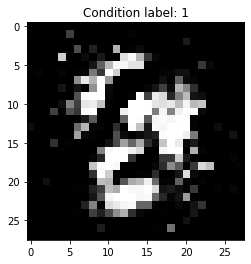

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  76.76it/s  0.5562  0.7085   11    5158             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

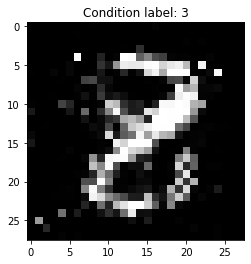

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  81.48it/s  0.4209  1.1833   12    5627             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

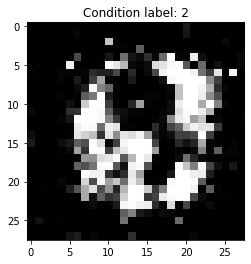

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  81.20it/s  0.5751  1.0998   13    6096             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

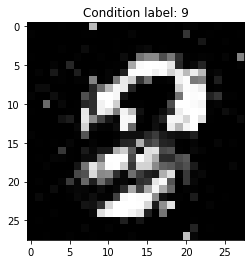

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  78.31it/s  0.5156  1.8359   14    6565             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

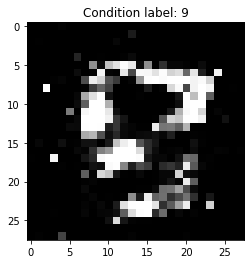

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  81.16it/s  0.5975  1.0284   15    7034             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

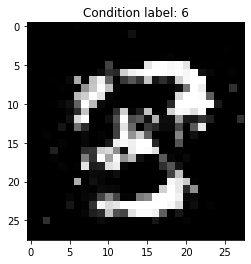

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  77.93it/s  0.6097  1.2849   16    7503             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

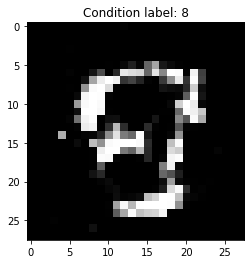

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  82.12it/s  0.5903  1.0418   17    7972             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

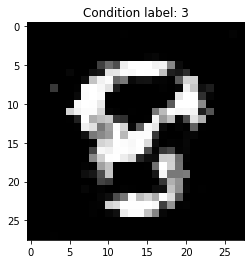

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  84.30it/s  0.6356  1.2116   18    8441             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

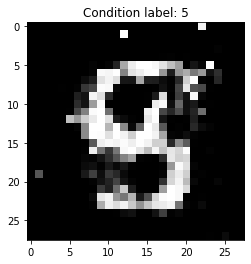

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  77.23it/s  0.5938  0.8194   19    8910             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

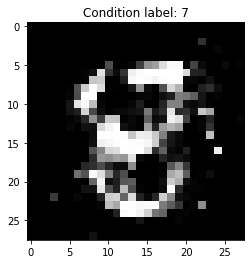

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  80.42it/s  0.5938  1.1644   20    9379             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

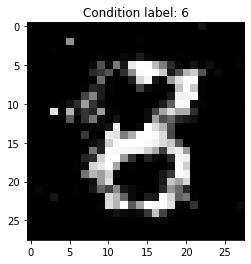

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  78.22it/s  0.6027  1.1164   21    9848             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

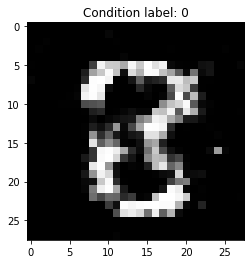

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  79.25it/s  0.6879  0.8148   22    10317            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

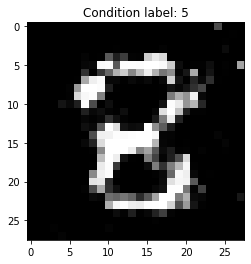

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  82.38it/s  0.626   0.9868   23    10786            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

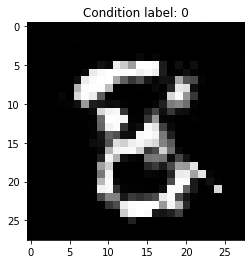

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  78.35it/s  0.5914  1.1877   24    11255            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

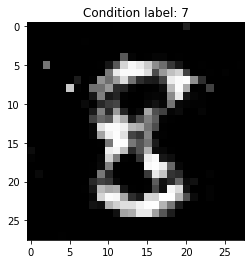

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  78.16it/s  0.6334  1.1224   25    11724            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

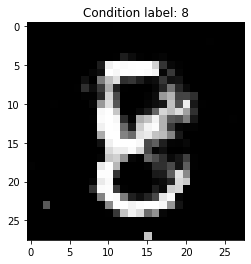

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  80.88it/s  0.6378  1.0231   26    12193            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

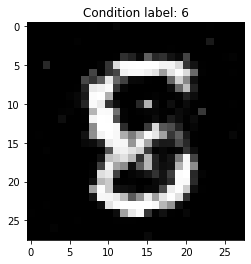

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  78.04it/s  0.6025  1.1376   27    12662            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

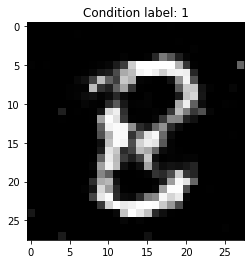

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  82.00it/s  0.6312  1.0493   28    13131            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

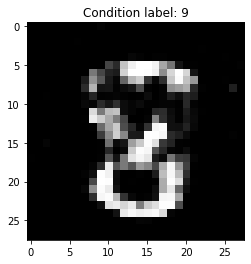

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  77.53it/s  0.6354  1.2663   29    13600            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

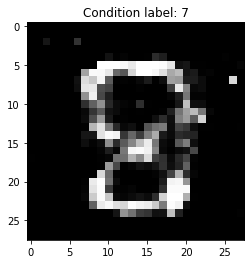

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  80.77it/s  0.5923  0.9965   30    14069            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

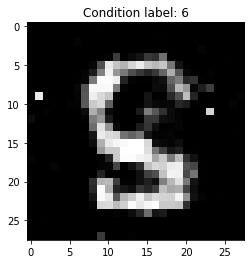

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  80.63it/s  0.6423  1.0353   31    14538            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

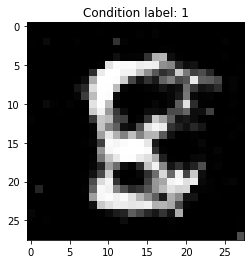

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  77.48it/s  0.6253  0.8348   32    15007            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

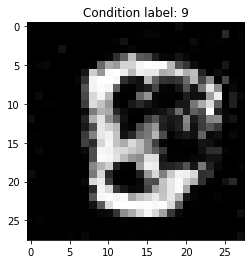

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  82.42it/s  0.6207  0.7877   33    15476            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

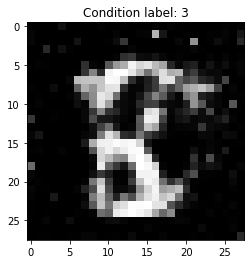

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  79.51it/s  0.5816  1.0064   34    15945            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

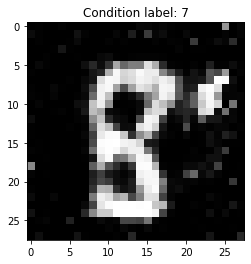

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  78.34it/s  0.6643  0.8982   35    16414            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

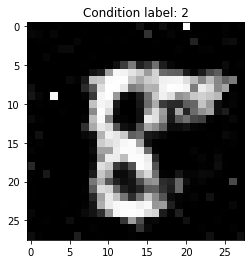

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  79.05it/s  0.6299  1.1304   36    16883            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

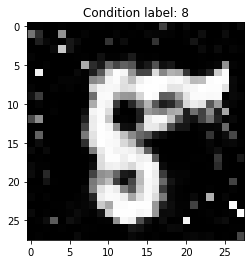

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  78.56it/s  0.6476  1.1418   37    17352            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

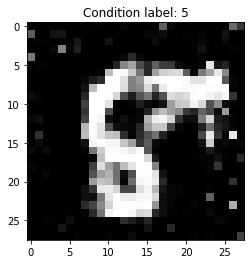

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  83.65it/s  0.6541  1.1121   38    17821            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

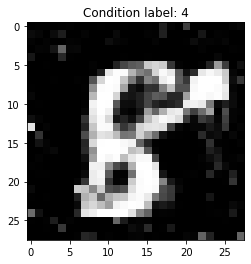

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  82.61it/s  0.6358  0.9881   39    18290            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

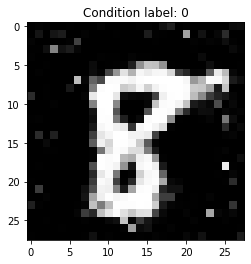

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  78.54it/s  0.6458  0.8511   40    18759            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

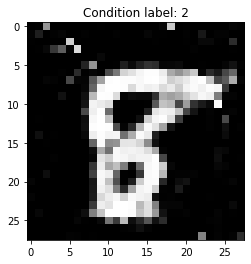

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  82.15it/s  0.6503  1.2981   41    19228            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

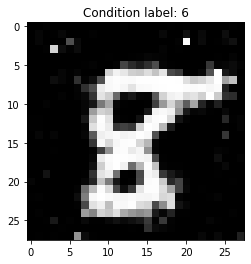

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  78.84it/s  0.6369  0.7081   42    19697            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

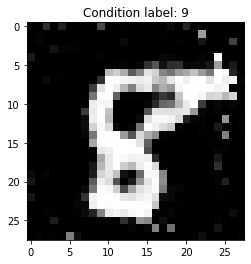

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  83.72it/s  0.6738  1.0215   43    20166            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

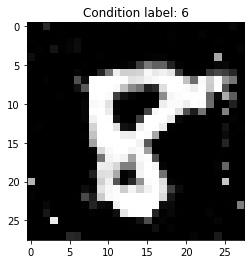

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  80.56it/s  0.6111  0.7784   44    20635            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

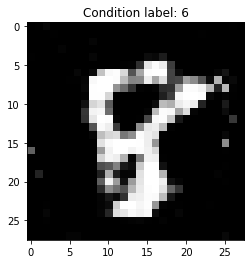

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  78.93it/s  0.6136  0.7489   45    21104            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

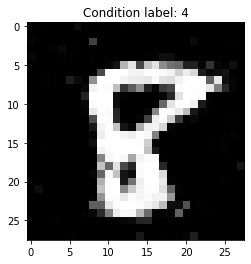

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  83.08it/s  0.6535  1.0321   46    21573            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

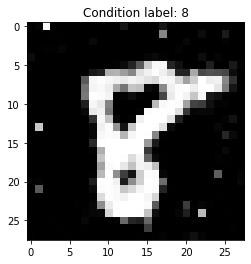

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  78.40it/s  0.6444  1.0144   47    22042            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

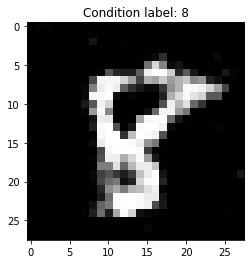

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  80.18it/s  0.6704  0.9871   48    22511            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

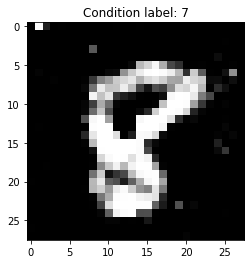

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  82.05it/s  0.6371  0.8871   49    22980            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

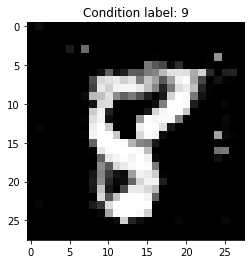

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  77.46it/s  0.6314  1.0007   50    23449            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

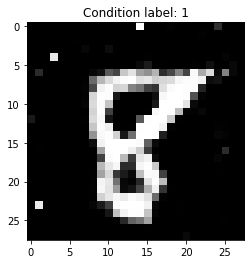

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  80.97it/s  0.6367  0.9051   51    23918            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

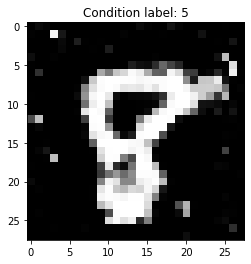

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  80.19it/s  0.6976  0.8818   52    24387            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

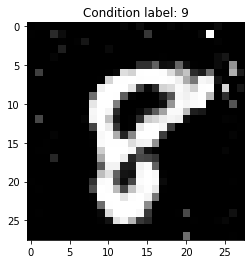

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  78.37it/s  0.6144  0.9077   53    24856            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

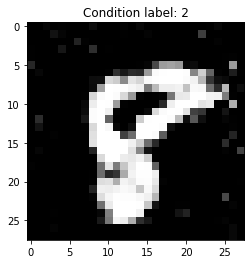

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  80.82it/s  0.6195  0.851    54    25325            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

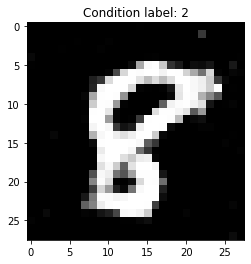

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  77.72it/s  0.6716  0.9343   55    25794            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

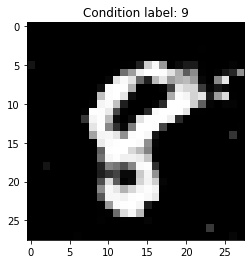

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  81.87it/s  0.655   1.1586   56    26263            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

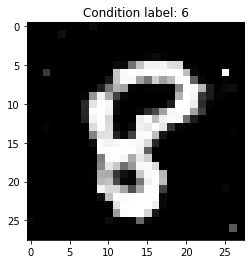

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  81.56it/s  0.6204  0.9309   57    26732            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

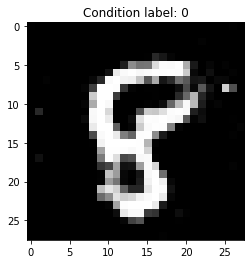

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  77.81it/s  0.6476  0.9981   58    27201            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

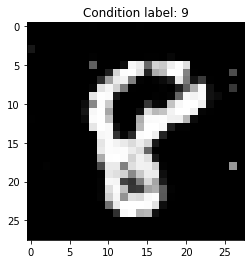

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  81.83it/s  0.6512  0.8012   59    27670            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

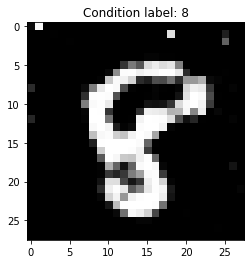

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  78.09it/s  0.6485  0.806    60    28139            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

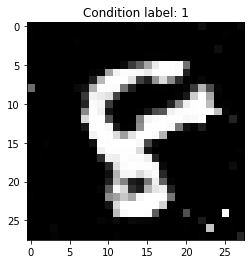

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  79.77it/s  0.6017  0.9441   61    28608            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

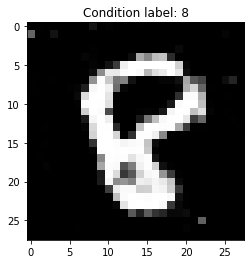

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  84.06it/s  0.6567  0.8067   62    29077            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

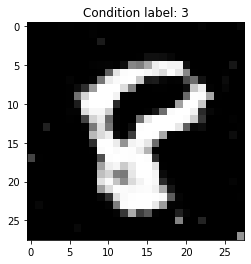

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  75.65it/s  0.6332  0.9539   63    29546            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

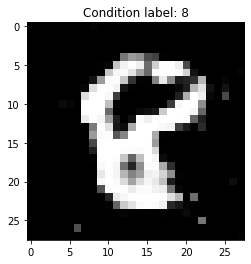

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  83.32it/s  0.6331  0.9519   64    30015            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

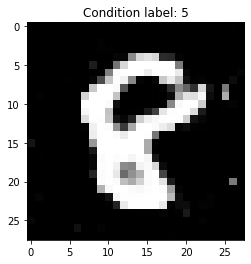

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  80.21it/s  0.6246  0.9179   65    30484            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

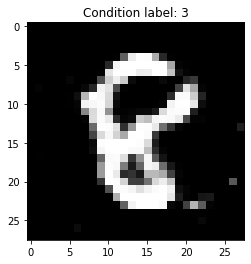

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  78.46it/s  0.6585  0.9447   66    30953            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

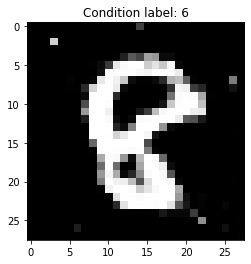

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  82.12it/s  0.6613  0.7996   67    31422            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

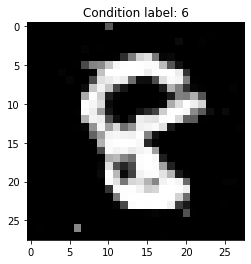

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  77.00it/s  0.6442  0.9342   68    31891            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

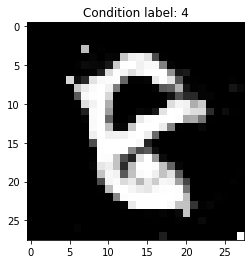

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  82.46it/s  0.5974  0.8892   69    32360            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

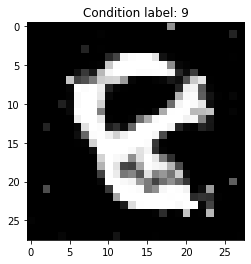

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  81.44it/s  0.6735  0.8409   70    32829            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

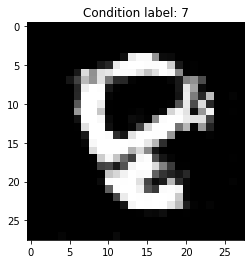

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  77.33it/s  0.6317  0.8088   71    33298            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

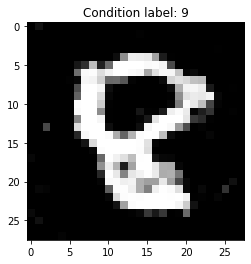

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  81.80it/s  0.6282  0.8088   72    33767            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

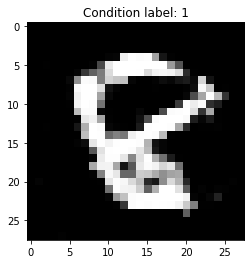

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  77.51it/s  0.6348  0.8088   73    34236            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

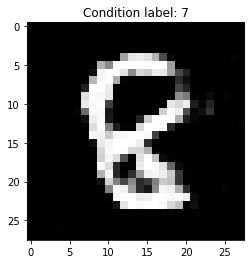

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  79.57it/s  0.6204  0.8272   74    34705            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

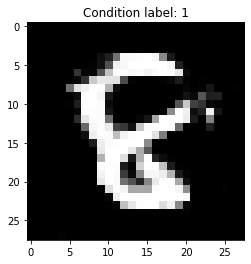

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  84.05it/s  0.6447  0.7979   75    35174            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

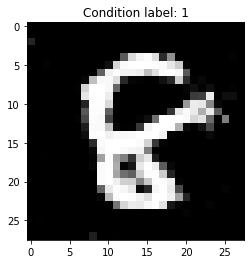

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  77.78it/s  0.6356  0.8375   76    35643            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

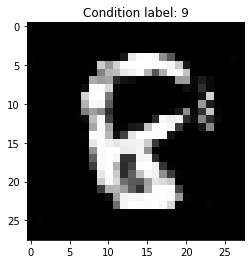

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  82.29it/s  0.6489  0.7297   77    36112            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

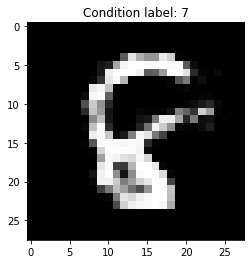

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  81.15it/s  0.6676  0.8329   78    36581            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

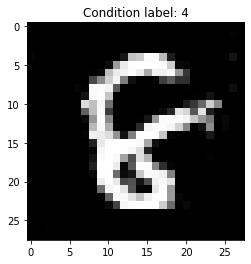

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  77.13it/s  0.6389  1.0082   79    37050            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

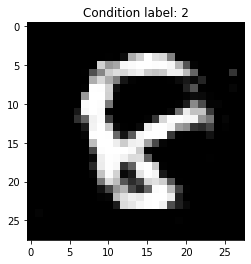

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  82.17it/s  0.6531  0.7889   80    37519            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

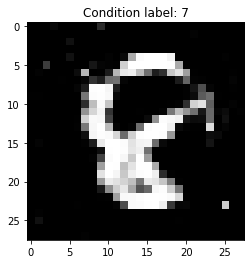

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  78.58it/s  0.6481  0.9527   81    37988            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

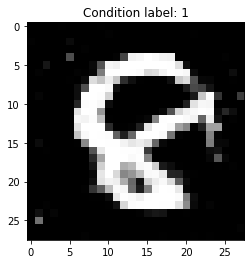

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  79.91it/s  0.6532  0.8627   82    38457            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

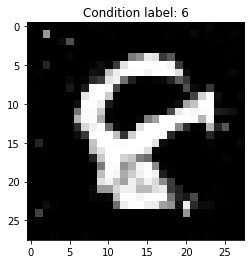

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  81.41it/s  0.6687  0.8993   83    38926            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

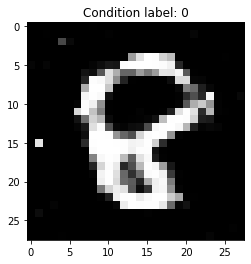

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  77.75it/s  0.6503  0.8563   84    39395            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

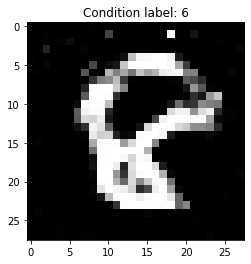

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  80.93it/s  0.656   0.8513   85    39864            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

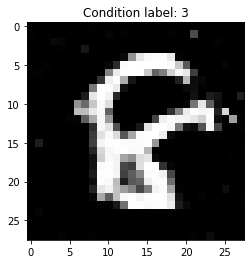

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  77.75it/s  0.6589  1.0255   86    40333            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

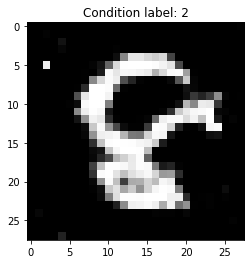

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  77.57it/s  0.6573  0.7423   87    40802            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

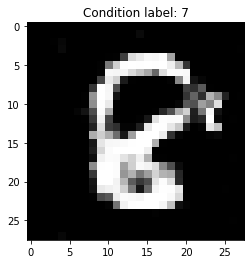

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  82.48it/s  0.6429  0.7896   88    41271            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

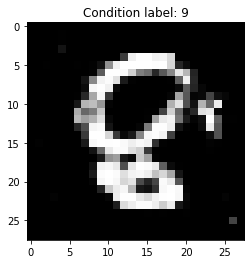

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  76.25it/s  0.6679  0.9348   89    41740            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

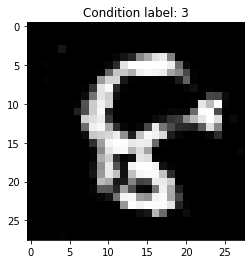

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  87.93it/s  0.6495  0.8217   90    42209            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

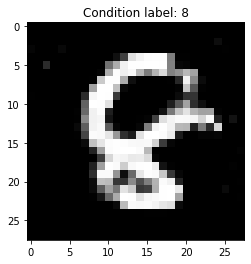

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  78.25it/s  0.6404  0.8216   91    42678            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

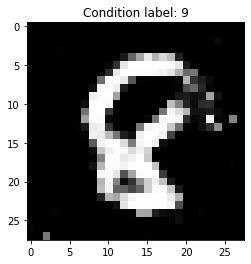

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  78.48it/s  0.6339  1.0542   92    43147            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

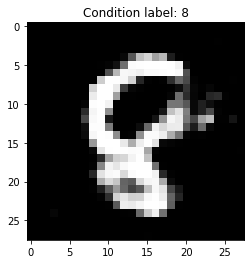

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  82.47it/s  0.6428  0.8302   93    43616            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

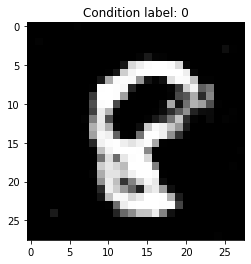

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  77.24it/s  0.6384  0.951    94    44085            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

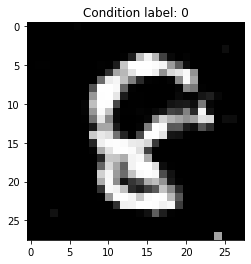

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  80.93it/s  0.5981  0.7721   95    44554            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

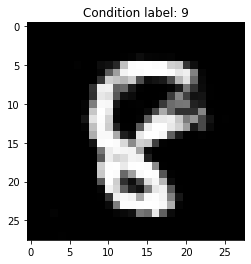

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  80.17it/s  0.6843  0.8545   96    45023            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

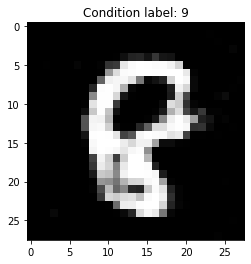

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  78.04it/s  0.6657  0.8679   97    45492            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

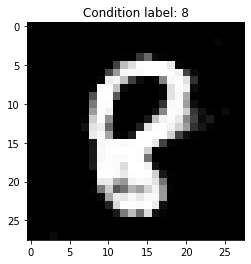

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  84.04it/s  0.6322  1.0807   98    45961            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

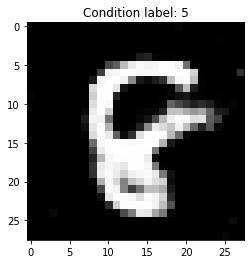

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:06<00:00:00  76.40it/s  0.6879  0.9052   99    46430            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

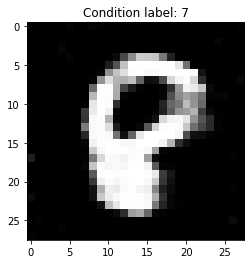

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 469/469  00:00:05<00:00:00  82.99it/s  0.6437  0.9603   100   46899            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

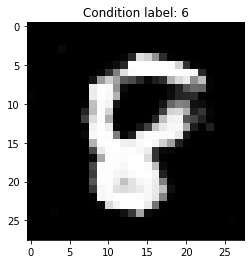

Evaluation done!


In [65]:
# Training Loop
iters = 0
lossD = []
lossG = []
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    progress_bar = qqdm(train_dataloader)
    netG.train()
    netD.train()
    # For each batch in the dataloader
    for i, data in enumerate(progress_bar):

        ############################
        # (1) Update D network
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        true_img = data[0].view(-1, image_size*image_size).to(device)
        b_size = true_img.size(0)
        digit_labels = data[1].to(device)
        # Forward pass real batch through D
        pred_real = netD(true_img, digit_labels).view(-1)
        # Calculate loss on all-real batch
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        errD_real = criterionGAN(pred_real, label)

        ## Train with all-fake batch
        # Generate fake image batch with G
        noise = torch.randn(b_size, nz, device=device)
        fake_labels = torch.randint(0, 10, (b_size,), device=device)
        fake = netG(noise, fake_labels)
        # Classify all fake batch with D
        pred_fake = netD(fake.detach(), fake_labels).view(-1)
        # Calculate D's loss on the all-fake 
        label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        errD_fake = criterionGAN(pred_fake, label)

        # Compute error of D as sum over the fake and the real batches
        errD = (errD_real + errD_fake)*0.5
        # Calculate the gradients for this batch
        errD.backward()
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        fake = netG(noise, fake_labels)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        pred_fake = netD(fake, fake_labels).view(-1)
        label.fill_(real_label)   # fake labels are real for generator cost
        # Calculate G's loss based on this output
        errG = criterionGAN(pred_fake, label)
        # Calculate gradients for G
        errG.backward()
        # Update G
        optimizerG.step()

        # Output training stats\
        # Set the info of the progress bar
        # Note that the value of the GAN loss is not directly related to
        # the quality of the generated images.
        progress_bar.set_infos({
            'Loss_D': round(errD.item(), 4),
            'Loss_G': round(errG.item(), 4),
            'Epoch': epoch+1,
            'Step': iters,
        })
        #save loss for plt
        lossD.append(errD.item())
        lossG.append(errG.item())


        iters += 1
    

    # Evaluation 
    netG.eval()
    with torch.no_grad():
        generated_imgs = netG(fixed_noise, fixed_labels)
        show_imgs = generated_imgs.cpu().view(-1, image_size, image_size)
        # Save evaluation results
        if (epoch+1) % save_steps == 0:
            filename = os.path.join(log_dir, f'Epoch_{epoch+1:03d}.jpg')
            img_samples = (generated_imgs.view(-1, 1, image_size, image_size).data + 1) / 2.0
            torchvision.utils.save_image(img_samples, filename, nrow=10)
        for x in show_imgs:
            plt.title('Condition label: {}'.format(str(fake_labels[0].item())))
            plt.imshow(x.detach().numpy(), interpolation='nearest',cmap='gray')
            plt.show()
            break
    print('Evaluation done!')

    # Save the checkpoints.
    if (epoch+1) % save_steps == 0:
        netG_out_path = os.path.join(ckpt_dir, 'netG_epoch_{}.pth'.format(epoch+1))
        netD_out_path = os.path.join(ckpt_dir, 'netD_epoch_{}.pth'.format(epoch+1))
        torch.save(netG.state_dict(), netG_out_path)
        torch.save(netD.state_dict(), netD_out_path)

## Plot the generator and discriminator loss

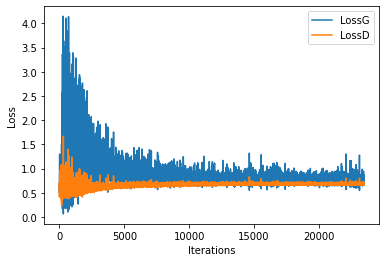

In [15]:
###############################################################################
# TODO: Plot the training loss value of discriminator and generator
# Implementation 1-2
###############################################################################
length = len(lossG)
plt.plot(np.arange(0, length), lossG, label="LossG")
plt.plot(np.arange(0, length), lossD, label="LossD")
plt.legend(loc='upper right')
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.show()



# Inference

The trained model should has been saved in the directory(ckpt_dir) you specified.

Use the trained model to generate images with condition!

## Load trained model

In [14]:
import torch

# load gernerator
device = torch.device("cuda")
netG = Generator()
netG.load_state_dict(torch.load(os.path.join(ckpt_dir, 'netG_epoch_{}.pth'.format(25))))
netG.eval()
netG.to(device)

Generator(
  (label_embedding): Embedding(10, 10)
  (main): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

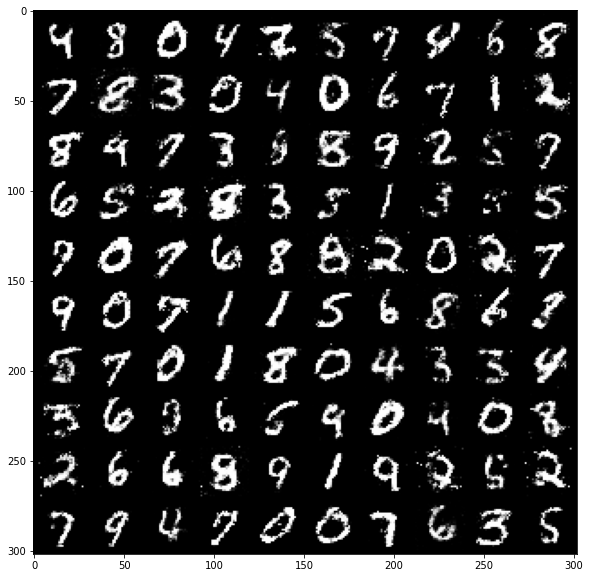

In [15]:
###############################################################################
# TODO: Store the generated 10*10 grid images
# Implementation 1-3
###############################################################################

# Generate 100 images and make a grid to save them.
n_output = 100
fixed_noise = torch.randn(100, nz, device=device)
fixed_labels = torch.randint(0, nclass, (100,)).to(device)
imgs_sample = netG(fixed_noise, fixed_labels)
img_samples = (imgs_sample.view(-1, 1, image_size, image_size).data + 1) / 2.0
result_dir = os.path.join(workspace_dir, 'results/cGAN')
filename = os.path.join(result_dir, 'result.jpg')

# Show the images in notebook.
grid_img = torchvision.utils.make_grid(img_samples, nrow=10)
plt.figure(figsize=(10, 10))
plt.imshow(grid_img.cpu().permute([1, 2, 0]))
plt.show()

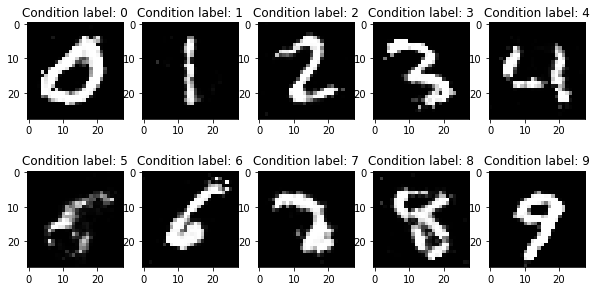

In [18]:
###############################################################################
# TODO: Generate images with specified condition labels
# Implementation 1-4
###############################################################################
fixed_noise = torch.randn(10, nz, device=device)
fixed_labels = torch.tensor([0,1,2,3,4,5,6,7,8,9]).to(device)
imgs_sample = netG(fixed_noise, fixed_labels)
show_imgs = imgs_sample.cpu().view(-1, image_size, image_size)
plt.figure(figsize=(10,5))
for index, x in enumerate(show_imgs):
    plt.subplot(2, 5, index+1)
    plt.title('Condition label: {}'.format(str(fixed_labels[index].item())))
    plt.imshow(x.detach().numpy(), interpolation='nearest',cmap='gray')
plt.show()